# pysvo tutorial

pysvo is a very basic python interface to the [Theoretical services of the Spanish Virtual Observatory](http://svo2.cab.inta-csic.es/theory/main/). 

The main functionalities right now are:
* Handling and downloading photometric [filter profiles](http://svo2.cab.inta-csic.es/theory/fps3/)
* Handling and downloading [synthetic spectra](http://svo2.cab.inta-csic.es/theory//newov2) (still in development)
* Fast calculation of extinction coefficients

### Getting started

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

### Photometric transmission curves

With the pysvo.photometry.PhotoFilter class you can download and handle photometric filter curves provided in the format of the Spanish Virtual Observatory:

In [2]:
from pysvo import photometry
u=photometry.PhotoFilter("SLOAN", "SDSS.u", "AB")

We have now successfully downloaded and read the transmission curve for the [SDSS u band filter](http://svo2.cab.inta-csic.es/theory/fps3/index.php?id=SLOAN/SDSS.u&&mode=browse&gname=SLOAN&gname2=SDSS#filter), in the AB magnitude system. (This typically produces an astropy warning that is irrelevant for us.) Let's plot the the transmission curve.

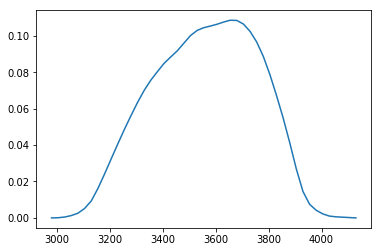

In [4]:
u.PlotTransmissioncurve()

Let's try something else: the [Herschel SPIRE PLW band](http://svo2.cab.inta-csic.es/theory/fps3/index.php?id=Herschel/SPIRE.PLW&&mode=browse&gname=Herschel&gname2=SPIRE#filter). (For a list of all more than 2300 available passbands see [the Filter Profile Service website](http://svo2.cab.inta-csic.es/theory/fps3/).)

In [5]:
plw=photometry.PhotoFilter("Herschel", "SPIRE.PLW", "AB")

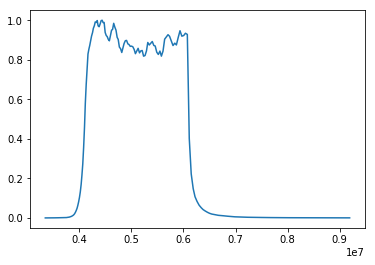

In [6]:
%matplotlib inline  
plw.PlotTransmissioncurve()

The photometry.PhotoFilter objects have some other attributes that you can get by typing, e.g.,

In [7]:
plw.WavelengthPeak   # All wavelengths are in Angstrom

4440497.3

In [8]:
plw.FWHM

1998631.380457

In [9]:
plw.Description

b'Herschel SPIRE PLW filter (point sources)'

### Synthetic spectra

The SVO also distributes stellar synthetic spectra. Since they are only available as batch download files, and since we only use them to calculate extinction coefficients, the current version of pysvo.synthspectra only supports the Kurucz and BT-Settl spectra. Assuming you have them downloaded in pysvo/spectrallib/, you can load an individual spectrum like this:

In [1]:
from pysvo import synthspectra
sun = synthspectra.SynSpectrum(lib="Kurucz", mh=0.0, teff=5750., logg=4.5)
sun.GetFlux(6563) # Get the flux at the Balmer alpha line 

array(6411558.65519272)

Now we can plot it:

[2000, 20000, -0.05, 10500000.0]

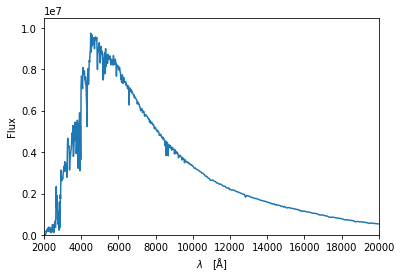

In [4]:
sun.PlotSpectrum()
plt.axis([2000,20000,-0.05,1.05e7])

### Extinction curves

The pysvo.extcurves module contains a few popular extinction curves, i.e. the relation $\frac{A_{\lambda}}{A_V}(\lambda)$. You can evaluate them by calling e.g.:

In [6]:
from pysvo import extcurves

wavelengtharray = np.linspace(4000,10000) # Everything is still in Angstroms
cardelli1989 = extcurves.Cardelli1989(wavelengtharray, RV=3.1)  # Default RV value for Cardelli's curve
schlafly2016 = extcurves.Schlafly2016(wavelengtharray, RV=3.32) # Default 'RV' value for Schlafly's curve

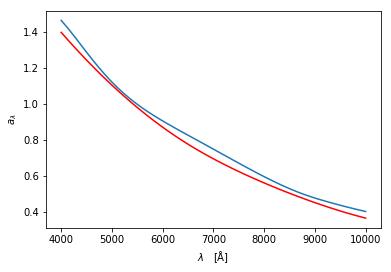

In [10]:
fig, ax = plt.subplots()
plt.plot(wavelengtharray, cardelli1989)
plt.plot(wavelengtharray, schlafly2016, c="r")
ax.set_xlabel(r"$\lambda\quad [{\rm \AA}]$")
ax.set_ylabel(r"$a_{\lambda}$")
plt.show()

Since the extinction module is very rudimentary, for older extinction curves it is recommended to use the [extinction module](https://extinction.readthedocs.io/en/latest/) instead.

### Extinction coefficients

The main function of this module is to compute fast extinction coefficients/bolometric corrections for arbitrary passbands available from the SVO Filter Profile Service. It works like this:

Let us first assume that the filter is sufficiently narrow so that it doesn't depend too much on extinction itself, or the properties of the source spectrum:

$$ \dfrac{A_{\rm filter}}{A_V} \sim \int A_{\lambda} T_{\lambda}^{\rm filter} d\lambda $$

We can get this rough estimate for the SDSS u band by simply computing

In [14]:
u.getAlambda_rough(extlaw='schlafly', RV=3.32)

1.5466286598581969

Now, for intermediate and broad photometric filters the extinction coefficient also depends on extinction itself, and on the source spectrum:

$$ \frac{A_{\rm filter}}{A_V} = \frac{2.5}{A_V} \cdot \log_{10} \dfrac{\int F_{\lambda} \cdot T^{\rm filter}_{\lambda} {\rm d}\lambda}{\int F_{\lambda} \cdot T^{\rm filter}_{\lambda} \cdot 10^{-0.4 a_{\lambda}\cdot A_V}{\rm d}\lambda} $$

A more can thus be computed when the source spectrum is given. For the solar-like spectrum hidden behind a V-band extinction of $A_V=1$, this would give us:

In [15]:
u.getAlambda_1spec(extlaw='schlafly', RV=3.32, lib="Kurucz", 
                        teff=5750., logg=4.5, mh=0.0, AV=1., 
                        kind="cubicspline")

1.5388880518137258

I.e. a value very close to the rough estimate we had before. What happens if we are looking at a highly reddened red dwarf star instead? 

In [16]:
u.getAlambda_1spec(extlaw='schlafly', RV=3.32, lib="Kurucz", 
                        teff=3500., logg=4.5, mh=0.0, AV=4.)

1.5136335528513616

Thus, to zeroth order, the extinction coefficient is constant. To first order, it depends on $A_V$ and on the effective temperature of the source, $T_{\rm eff}$. The built-in function PhotoFilter.evalAlambda_2D computes the extinction coefficient for a grid of $T_{\rm eff}$ and $A_V$ values and interpolates the results:

In [17]:
# Create some example values
Teff = np.array([3880., 6020., 11600.4])
AV   = np.array([6., 3., 0.3])
# Get the a_u at the respective combination of Teff and AV values:
u.evalAlambda_2D(Teff, AV)

Calculating extinction coefficient grid for filter  SDSS.u
Fitting polynomial of order  2


array([1.51952819, 1.52867574, 1.54360988])

Finally, to demonstrate that this makes much more of a difference for broader filters, let's compute the extinction coefficient for the Gaia G band on a grid of effective temperatures and extinctions:

Calculating extinction coefficient grid for filter  GAIA2m.G
Fitting polynomial of order  2


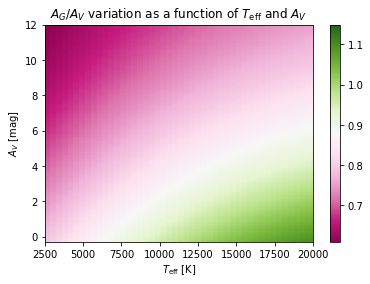

In [38]:
# Load the Gaia DR2 G band (using the transmission curve of Maiz & Weiler 2018)
G = photometry.PhotoFilter("GAIA", "GAIA2m.G", "Vega")

# Create a (Teff, AV) grid
teff=np.linspace(2500., 40000., 100)
av=np.linspace(-.3,12, 100)
X, Y = np.meshgrid(teff,av)

# Plot the results of G.evalAlambda_2D(X, Y)
fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, G.evalAlambda_2D(X, Y), cmap=plt.get_cmap('PiYG'))
fig.colorbar(im, ax=ax)
ax.set_xlabel(r"$T_{\rm eff}$ [K]")
ax.set_ylabel(r"$A_V$ [mag]")
ax.set_title(r"$A_G / A_V$ variation as a function of $T_{\rm eff}$ and $A_V$")
ax.axis([2500,20000,-.3,12])
plt.show()